In [15]:
import pandas as pd
import re
from tqdm import tqdm
import numpy as np
import itertools
from matplotlib import pyplot as plt

from ms_entropy.file_io.msp_file import read_one_spectrum
import numba as nb
import pyteomics.mgf
import sys
import importlib
import re


sys.path.append("../../src/ms_similarity_metrics/")
from create_spectrum import smile2inchi
from reformat_columns import reformat_columns
importlib.reload(sys.modules['create_spectrum'])
importlib.reload(sys.modules['reformat_columns'])
from create_spectrum import smile2inchi
from reformat_columns import reformat_columns


In [2]:
QUERY_DIR = '../../data/spec_entropy_queries/'
QUERY_PATH = 's3://enveda-data-user/chloe.engler/cosine_similarity/spec_entropy_queries/'
DATA_DIR = '../../data/'

UNWEIGHTED_FILE = 'filtered_10_ppm'
WEIGHTED_FILE = 'weighted_filtered_10_ppm'

# Get queries

In [17]:
# List of metrics that were used in the queries
metric_names = ['bhattacharya_2', 'manhattan', 'entropy']

# Read in the queries
# queries = pd.read_csv(f'{QUERY_PATH}{UNWEIGHTED_FILE}.csv', index_col=0)
# weighted_queries = pd.read_csv(f'{QUERY_PATH}{WEIGHTED_FILE}.csv', index_col=0)
queries = pd.read_csv(f'{QUERY_DIR}{UNWEIGHTED_FILE}_with_stats.csv', index_col=0)
weighted_queries = pd.read_csv(f'{QUERY_DIR}{WEIGHTED_FILE}_with_stats.csv', index_col=0)

# Filter the queries to only include queries that were in both the weighted and unweighted queries
queries = queries[queries['wout_identifier'].isin(weighted_queries['wout_identifier'])]
weighted_queries = weighted_queries[weighted_queries['wout_identifier'].isin(queries['wout_identifier'])]

In [18]:
# Get column names that need reformatting
column_names = ['exact_matches', 
                'inchis', 
                'smiles', 
                'tanimoto']
all_column_names = metric_names.copy()
for name in column_names:
    all_column_names += [x for x in list(queries.columns) if name in x and 'wout' not in x]

In [19]:
# Reformat columns in the query dataframe
queries = reformat_columns(all_column_names,
                            query_type='spectral_entropy',
                            query_df=queries,
                            metric_names=metric_names)

# Reformat columns in the weightd query dataframe
weighted_queries = reformat_columns(all_column_names,
                                    query_type='spectral_entropy',
                                    query_df=weighted_queries,
                                    metric_names=metric_names)


100%|██████████| 25437/25437 [00:00<00:00, 49224.50it/s]


# Look at number of matches

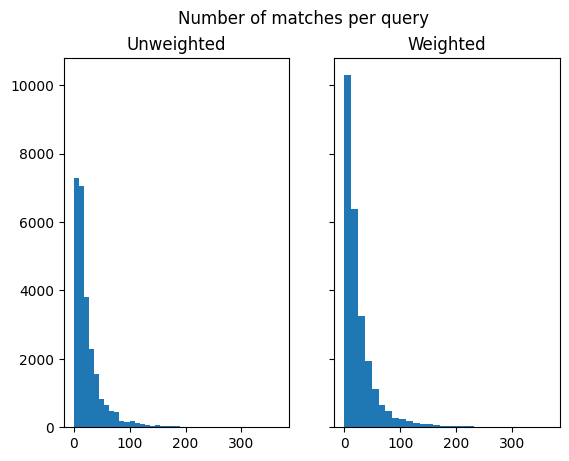

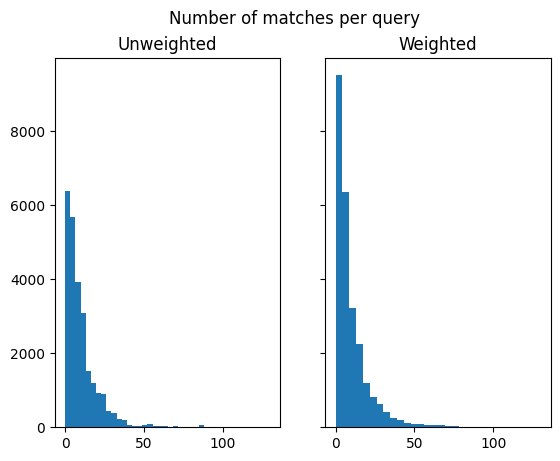

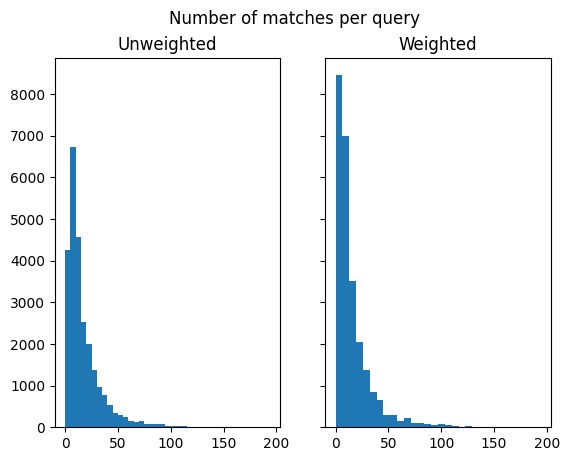

In [20]:
# Look at the number of matches per query for each metric
for name in metric_names:
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True)

    # Plot the number of matches per query for the unweighted queries
    num_matches = queries[name].apply(lambda x: len(x))
    ax1.hist(num_matches, bins=30)
    ax1.set_title('Unweighted')

    # Plot the number of matches per query for the weighted queries
    num_matches = weighted_queries[name].apply(lambda x: len(x))
    ax2.hist(num_matches, bins=30)
    ax2.set_title('Weighted')

    # Show plot
    plt.suptitle('Number of matches per query')
    plt.show()

# Look at exact matches

In [21]:
# Set initial variables
all_ranks = {}
all_ranks_weighted = {}
all_ranks_combined = {}
all_rank_1 = {}
all_rank_1_weighted = {}
all_rank_1_combined = {}

for name in metric_names:
    # Get all ranks of exact matches for unweighted queries
    all_ranks[name] = list(itertools.chain(*list(queries[f'{name}_exact_matches'])))
    all_ranks_weighted[name] = list(itertools.chain(*list(weighted_queries[f'{name}_exact_matches'])))

    # Get each highest rank of exact matches for unweighted queries
    all_rank_1[name] = [x[0] for x in queries[f'{name}_exact_matches'] if len(x) > 0]
    all_rank_1_weighted[name] = [x[0] for x in weighted_queries[f'{name}_exact_matches'] if len(x) > 0 ]

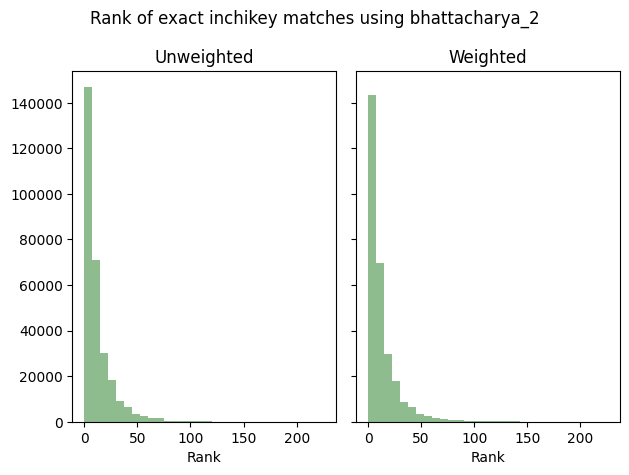

bhattacharya_2: 
Average unweighted top rank:  7.0
Average weighted top rank:  8.0




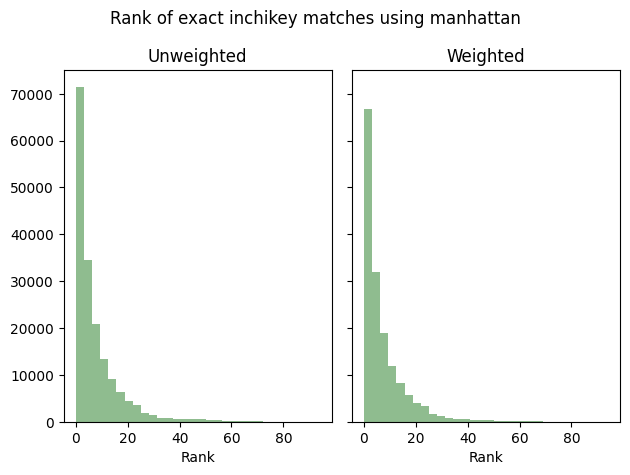

manhattan: 
Average unweighted top rank:  5.0
Average weighted top rank:  4.0




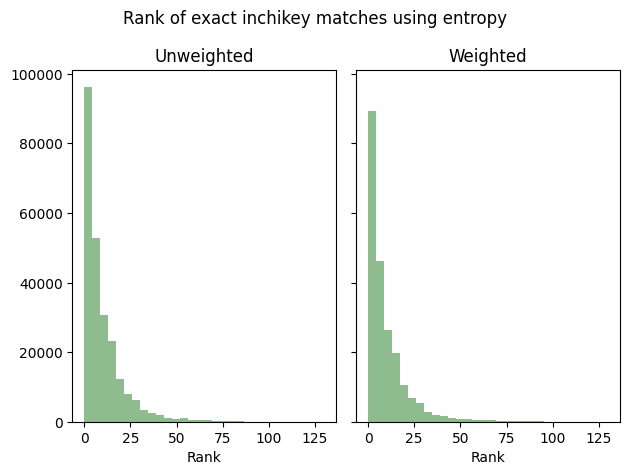

entropy: 
Average unweighted top rank:  6.0
Average weighted top rank:  6.0




In [22]:
# Set initial variables
xlim = {'bhattacharya_2': 1000, 'manhattan': 250, 'entropy': 250}

# Plot the rank of exact matches for each metric
for name in metric_names:
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    # Plot the rank of exact matches for unweighted queries
    _,bins,_ = ax1.hist(all_ranks[name], bins=30, color='darkseagreen')
    ax1.set_title('Unweighted')
    ax1.set_xlabel('Rank')

    # Plot the rank of exact matches for weighted queries
    ax2.hist(all_ranks_weighted[name], bins=bins, color='darkseagreen')
    ax2.set_title('Weighted')
    ax2.set_xlabel('Rank')

    # Show plot
    plt.suptitle(f'Rank of exact inchikey matches using {name}')
    plt.tight_layout()
    #plt.savefig(f'../figures/rank_{name}.png')
    plt.show()

    print(f'{name}: ')
    print('Average unweighted top rank: ', np.median(all_ranks[name]))
    print('Average weighted top rank: ', np.median(all_ranks_weighted[name]))
    print('\n')

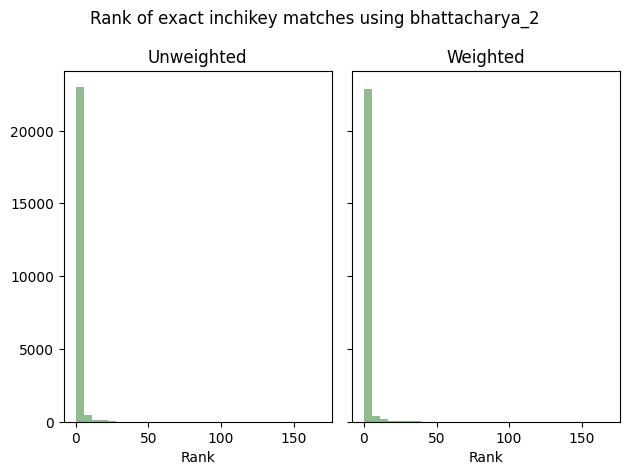

bhattacharya_2: 
Average unweighted rank:  7.0
Average weighted rank:  8.0


KeyError: 'bhattacharya_2'

In [23]:
# Plot the highest rank of exact matches for each metric
for name in metric_names:
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    # Plot the highest rank of exact matches for unweighted queries
    _,bins,_ = ax1.hist(all_rank_1[name], bins=30, color='darkseagreen')
    ax1.set_title('Unweighted')
    ax1.set_xlabel('Rank')

    # Plot the highest rank of exact matches for weighted queries
    ax2.hist(all_rank_1_weighted[name], bins=bins, color='darkseagreen')
    ax2.set_title('Weighted')
    ax2.set_xlabel('Rank')

    # Show plot
    plt.suptitle(f'Rank of exact inchikey matches using {name}')
    plt.tight_layout()
    plt.show()

    print(f'{name}: ')
    print('Average unweighted rank: ', np.median(all_ranks[name]))
    print('Average weighted rank: ', np.median(all_ranks_weighted[name]))
    print('Average combined rank: ', np.median(all_ranks_combined[name]))
    print('\n')

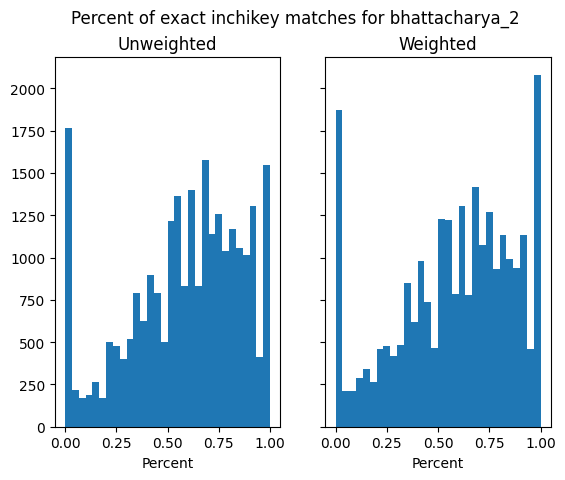

bhattacharya_2: 
Median percent exact matches for unweighted:  0.625
Median percent exact matches for weighted:  0.6153846153846154




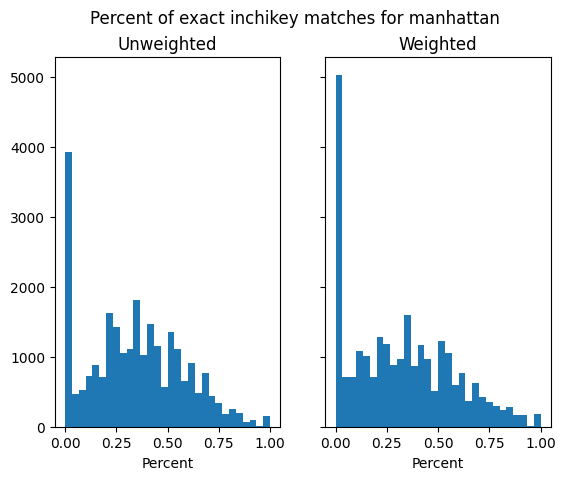

manhattan: 
Median percent exact matches for unweighted:  0.3333333333333333
Median percent exact matches for weighted:  0.3




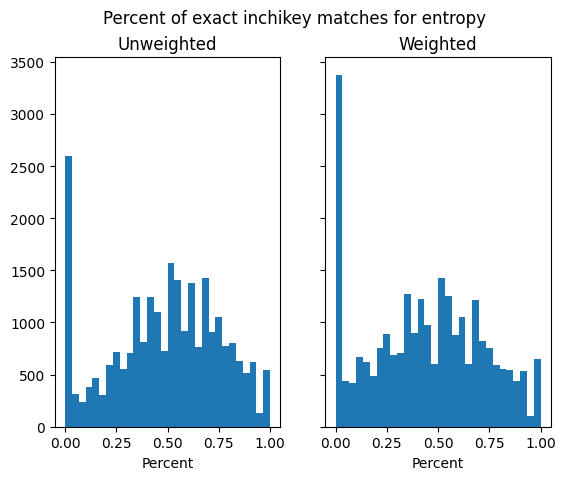

entropy: 
Median percent exact matches for unweighted:  0.5
Median percent exact matches for weighted:  0.4375




In [25]:
# Plot the percent of exact matches above the threshold for each metric
for name in metric_names:
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    # Plot the percent of exact matches above the threshold for unweighted queries
    ax1.hist(queries[f'{name}_percent_exact'], bins=30)
    ax1.set_title('Unweighted')
    ax1.set_xlabel('Percent')

    # Plot the percent of exact matches above the threshold for weighted queries
    ax2.hist(weighted_queries[f'{name}_percent_exact'], bins=30)
    ax2.set_title('Weighted')
    ax2.set_xlabel('Percent')


    # Show plot
    plt.suptitle(f'Percent of exact inchikey matches for {name}')
    plt.show()

    print(f'{name}: ')
    print('Median percent exact matches for unweighted: ', np.median(queries[f'{name}_percent_exact']))
    print('Median percent exact matches for weighted: ', np.median(weighted_queries[f'{name}_percent_exact']))
    print('\n')

# Look at top n matches

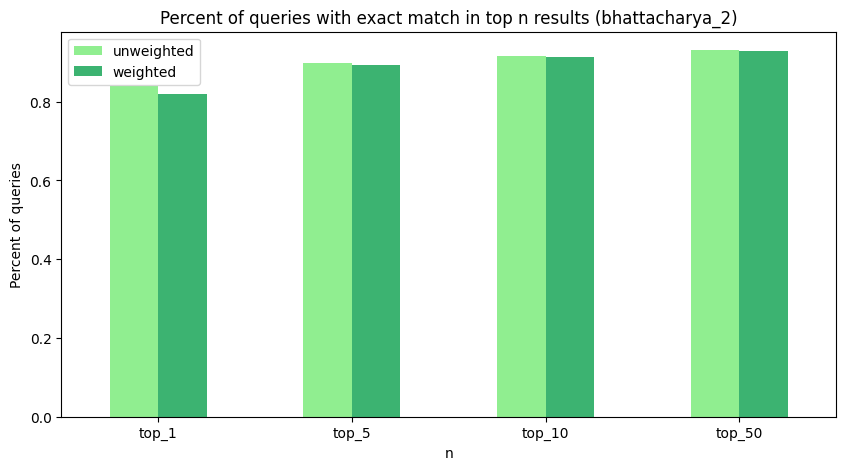

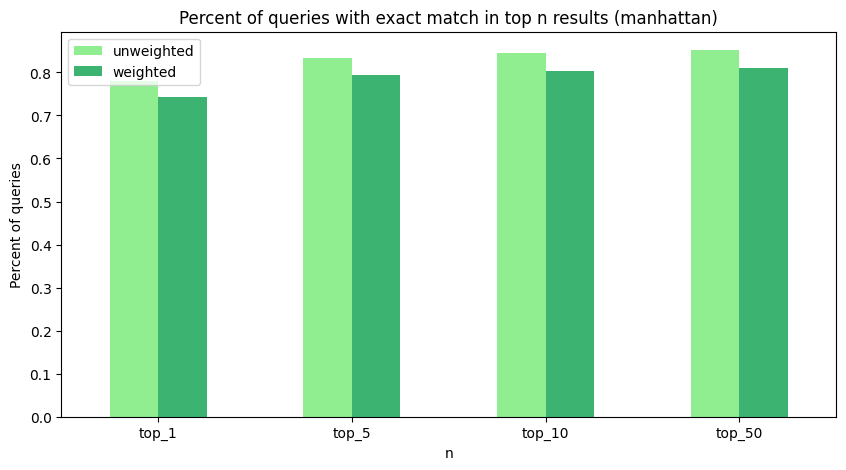

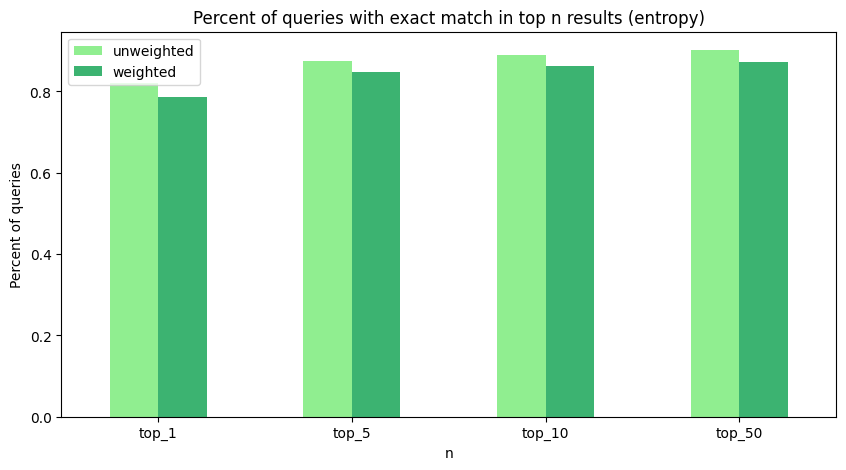

In [26]:
for name in metric_names:
    # Create data frame
    exact_matches_top_n = pd.DataFrame(columns=['unweighted', 'weighted'], 
                                    index=['top_1', 'top_5', 'top_10', 'top_50'])
    n_vals = [1, 5, 10, 50]

    # Get percent of queries with exact match in top 5
    for n in n_vals:
        exact_matches_top_n.loc[f'top_{n}', 'unweighted'] = queries.loc[queries[f'{name}_exact_matches'].apply(lambda x: min(x) \
                                                            if len(x) > 0 else np.nan)<n].shape[0] / queries.shape[0]
        exact_matches_top_n.loc[f'top_{n}', 'weighted'] =  weighted_queries.loc[weighted_queries[f'{name}_exact_matches'].apply(lambda x: min(x) \
                                                            if len(x) > 0 else np.nan)<n].shape[0] / weighted_queries.shape[0]

    # Create bar plot
    exact_matches_top_n.plot.bar(figsize=(10,5), rot=0, color=['lightgreen', 'mediumseagreen', 'darkgreen'])
    plt.title(f'Percent of queries with exact match in top n results ({name})')
    plt.ylabel('Percent of queries')
    plt.xlabel('n')
    plt.show()
    

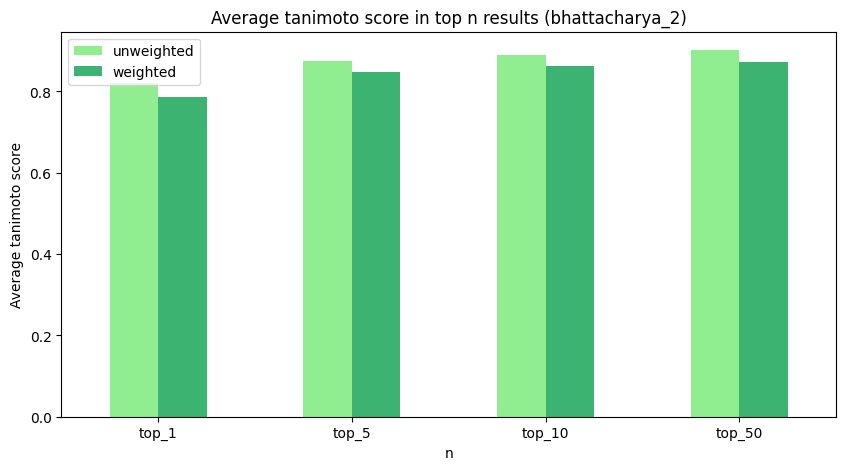

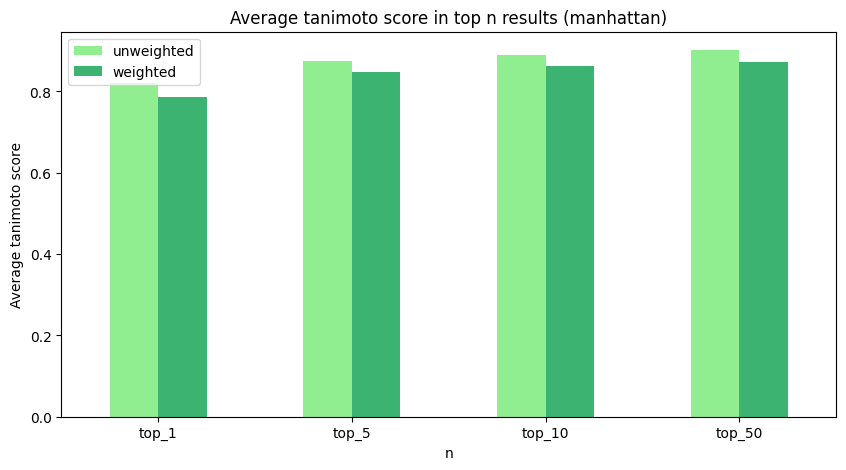

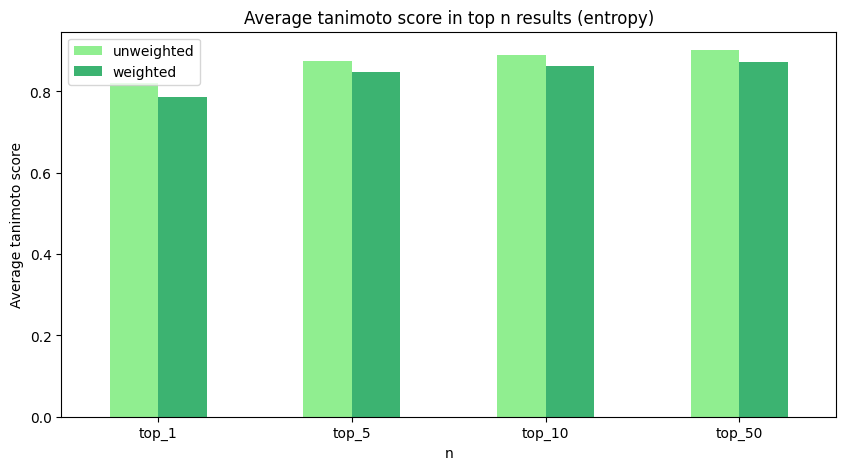

In [28]:
for name in metric_names:
    # Create data frame
    average_tanimoto_top_n = pd.DataFrame(columns=['unweighted', 'weighted'], 
                                        index=['top_1', 'top_5', 'top_10'])
    n_vals = [1, 5, 10]

    # Calculate average tanimoto score for top n results
    for i in n_vals:
        average_tanimoto_top_n.loc['unweighted', f'top_{n}'] = np.mean(list(itertools.chain.from_iterable([x[:n] for x in queries[f'{name}_tanimoto'] if len(x) > 0])))
        average_tanimoto_top_n.loc['weighted', f'top_{n}'] = np.mean(list(itertools.chain.from_iterable([x[:n] for x in weighted_queries[f'{name}_tanimoto'] if len(x) > 0])))

    # Create bar plot
    exact_matches_top_n.plot.bar(figsize=(10,5), rot=0, color=['lightgreen', 'mediumseagreen', 'darkgreen'])
    plt.title(f'Average tanimoto score in top n results ({name})')
    plt.ylabel('Average tanimoto score')
    plt.xlabel('n')
    plt.show()

# Look at AUC scores

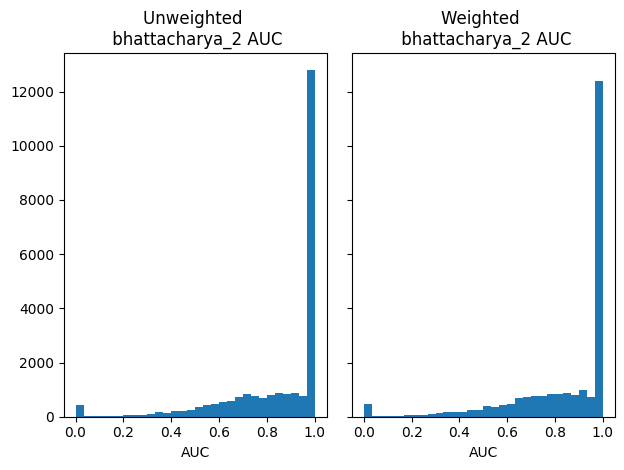

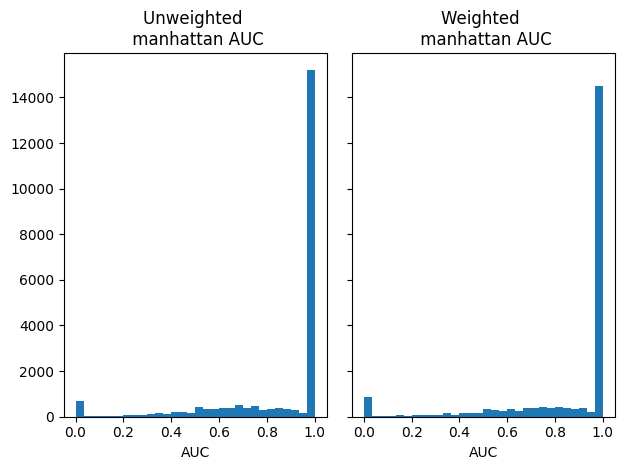

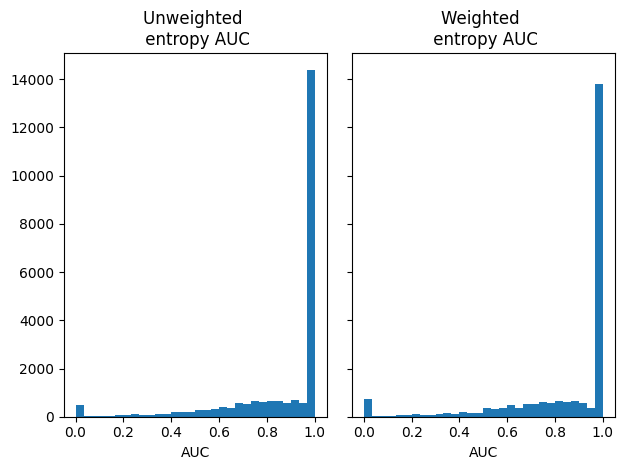

In [29]:
for name in metric_names:
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

    ax1.hist(queries[f'{name}_auc'], bins=30)
    ax1.set_title(f'Unweighted \n {name} AUC')
    ax1.set_xlabel('AUC')

    ax2.hist(weighted_queries[f'{name}_auc'], bins=30)
    ax2.set_title(f'Weighted \n {name} AUC')
    ax2.set_xlabel('AUC')

    plt.tight_layout()
    plt.show()
    